In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve, GridSearchCV
import matplotlib.pyplot as plt

In [2]:
def prepare_data(csv_file):
    """Prepare data.
    
    Separate target and feature columns.
    Make one-hot-encoding for day_name column.
    Make Scaling on feature columns.
    Train/Test Split.
            
        Parameters:
        -----------
        csv_file (str): File path to dataset.
        
        Returns:
        --------
        X_train, X_test, y_train, y_test: Train/Test data
    
    """
    df = pd.read_csv(csv_file)
    y = df.pop("demand") 

    # Do OneHotEncoding for the column day_name or use sine cosine transformation
    df = pd.get_dummies(df, columns=['day_name'])
    
    # Make train test split
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=1)
    
    # create scaler
    scaler = StandardScaler()
    
    # fit on train data
    scaler.fit(X_train)
    
    # Transfrom train and test 
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [3]:
def hyperparameter_optimization(X, y, model, param_grid):
    """Make hyperparameter optimization.
    
        Parameters:
        -----------
        X: Features of train data
        y: Target Column of train data
        model (SklearnModel): Model on which hyper. opt will be made.
        param_grid (dict): Parameter grid for GridSearch.
        
        Returns:
        --------
        SklearnModel: Best model found with GridSearch.
    
    """
    best_params = {}
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=2, return_train_score=True)
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_

In [4]:
def create_learning_curves(estimators, X_train, y_train):
    """Create learning curve for all best models.
    
        Parameters:
        -----------
        estimators (list): List of models found through hyperparameter opt.
        X_train: Features of train data
        y_train: Target Column of train data
    
    """
    for model in estimators: 
        model_name = model.__class__.__name__
        
        # Create plain untrained model instance
        params = model.get_params()
        # Create a new instance of the Model class with the same parameters
        untrained_model = model.__class__(**params)

        # Use cross validation cv = 10
        train_sizes, train_scores, test_scores = learning_curve(estimator=untrained_model, X=X_train, y=y_train,
                                                                cv=10, train_sizes=np.linspace(0.1, 1.0, 10), 
                                                                n_jobs=2)
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
        plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
        plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
        plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
        plt.title(f'Learning Curve for {model_name}')
        plt.xlabel('Training Data Size')
        plt.grid()
        plt.ylabel('Model accuracy')
        plt.legend(loc='lower right')
        plt.savefig(f'figures/learning_curve_{model_name}.png')
        plt.show()


In [5]:
def train_models(estimators, X_train, y_train):
    """Train models on train data.
    
        For every model type a hyperparameter optimization is done.
        For every best model of a model type, a learning curve is generated.
        The best estimators of each model type will be returned.
    
        Parameters:
        -----------
        estimators (list): List of tuples. Sklearn Model and param_grid dict.
        X_train: Features of train data
        y_train: Target Column of train data
        
        Returns:
        --------
        list: Best estimators (with best parameters) of each model type
    """
    best_estimators = []
    for (model, param_grid) in estimators:
        print(f"Start hyperparameter opt for: {model.__class__.__name__}")
        opt_model = hyperparameter_optimization(X_train, y_train, model, param_grid=param_grid)
        print(f"End hyperparameter opt for: {model.__class__.__name__}")

        best_estimators.append(opt_model)
    
    create_learning_curves(best_estimators, X_train, y_train)
    return best_estimators

In [6]:
# List of tuples of sklearn models and parameters for hyperparameter optimization
estimators = [
              # DecisionTree
              (DecisionTreeRegressor(), 
               {
                    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
                    'max_depth': [5, 10, 15, 20, None], 
                    'min_samples_split': [2, 5, 10], 
                    'min_samples_leaf': [1, 2, 4]
                } 
              ),
              
              # GradientBoosting
              (GradientBoostingRegressor(), 
               {
                    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
                    'criterion': ['friedman_mse', 'squared_error'],
                    'learning_rate': [0.1, 0.2],
                    'n_estimators': [100, 200],
                    'max_depth': [3, 8],
                    'max_features': ['auto', 'sqrt', 'log2', None]
                }
              ),
              
              # Support Vector Machine
              (SVR(),
               {
                    'C': [0.1, 0.5, 1, 10],
                    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                    'epsilon': [0.01, 0.05, 0.1, 1]
               }
              ),
        
              # MlPRegressor
              (MLPRegressor(),
               {
                    'hidden_layer_sizes': [(50,25, 10), (25,100,25)],
                    'activation': ['relu', 'tanh'],
                    'solver': ['sgd', 'adam'],
                    'alpha': [0.0001, 0.05],
                    'batch_size': [400],
                    'max_iter': [200]
               }
              
              )
            ]



Start hyperparameter opt for: DecisionTreeRegressor
End hyperparameter opt for: DecisionTreeRegressor
Start hyperparameter opt for: GradientBoostingRegressor
End hyperparameter opt for: GradientBoostingRegressor
Start hyperparameter opt for: SVR
End hyperparameter opt for: SVR
Start hyperparameter opt for: MLPRegressor


C:\Users\patri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [             nan  5.70681707e-001              nan  6.43865675e-001
 -1.51577946e+156  5.93261555e-001              nan  6.40743888e-001
  7.67746909e-002 -6.37067529e-001  1.08547858e-001 -3.77355453e-001
 -3.74092905e-004 -6.43215675e-001  1.90932900e-001 -3.78004539e-001]
  warnings.warn(
C:\Users\patri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: overflow encountered in square
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\patri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [             nan  5.84226187e-001              nan  6.61102844e-001
 -1.44488598e+156  6.09483816e-001              nan  6.54336979e-001
  8.49832225e-002 -6.36629405e-001  1.15373857e-001 -3.77002256e-001
 -1.65105550e

End hyperparameter opt for: MLPRegressor


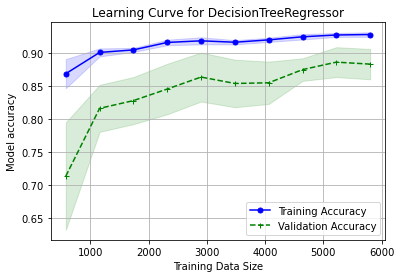

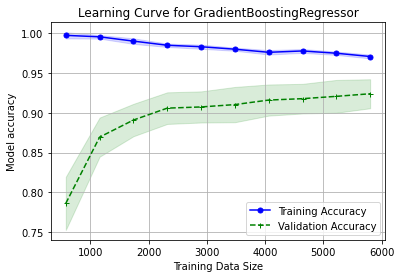

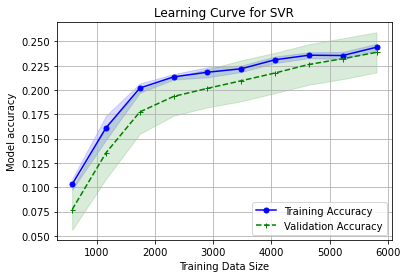

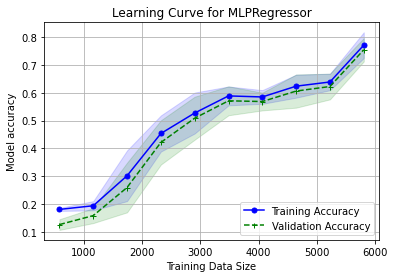

In [7]:
# Train Model for all_demand
X_train, X_test, y_train, y_test = prepare_data("data/all_demand.csv")

# train different model classes. Make Hyperparametrization for every model class.
# Then take the best model of each class and plot a learning curve
best_estimators = train_models(estimators, X_train, y_train)

In [8]:
# Test all best_estimators on test data and generate score
print(best_estimators)
estimator_scores = {}
for model in best_estimators:
    score = model.score(X_test, y_test)
    estimator_scores[model.__class__.__name__] = score
    
print("All best models with score: \n" + str(estimator_scores) + "\n")

# Take best model (with highest score)
model_name = max(estimator_scores, key=lambda k: estimator_scores[k])
print(f"The best model is: {model_name}")

best_model = [model for model in best_estimators if model_name==model.__class__.__name__][0]
print(best_model)

[DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=4,
                      min_samples_split=10), GradientBoostingRegressor(criterion='squared_error', loss='huber', max_depth=8,
                          max_features='auto', n_estimators=200), SVR(C=10), MLPRegressor(batch_size=400, hidden_layer_sizes=(25, 100, 25))]
All best models with score: 
{'DecisionTreeRegressor': 0.8922773722480211, 'GradientBoostingRegressor': 0.9348085240445432, 'SVR': 0.24842554721688237, 'MLPRegressor': 0.8120697351786464}

The best model is: GradientBoostingRegressor
GradientBoostingRegressor(criterion='squared_error', loss='huber', max_depth=8,
                          max_features='auto', n_estimators=200)


In [9]:
predictions = best_model.predict(X_test)

df = pd.DataFrame({"y_true": y_test, 'y_predicted': predictions})
df = df.sort_values("y_true")
df

,y_true,y_predicted
4058,1,5.116557
4936,1,1.572546
3230,1,4.906260
7381,1,3.941763
8177,1,7.864534
...,...,...
6746,1106,994.679045
7835,1204,619.543073
1820,1426,718.618505
2106,1584,750.852332


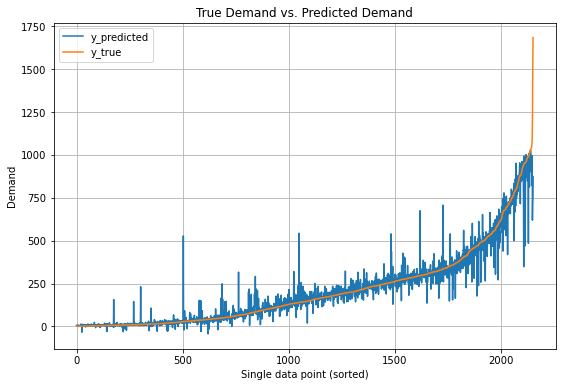

In [10]:
# plot lines
x = [i for i in range(0, len(df["y_true"]))]

plt.figure(figsize=(9, 6))
plt.title('True Demand vs. Predicted Demand')
plt.xlabel('Single data point (sorted)')
plt.grid()
plt.ylabel('Demand')

plt.plot(x, df["y_predicted"], label = "y_predicted")

plt.plot(x, df["y_true"], label = "y_true")

plt.legend()
plt.savefig(f'figures/True_demand_vs_predicted_demand.png')
plt.show()

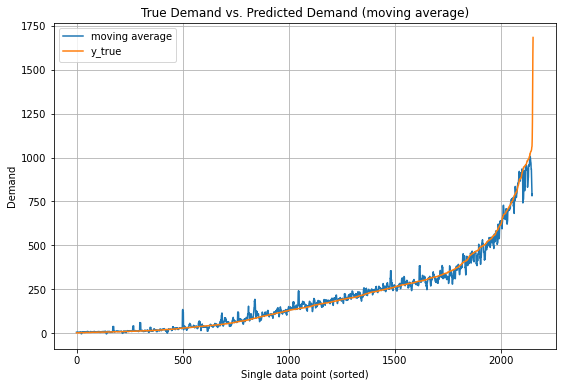

In [11]:
plt.figure(figsize=(9, 6))

# Calculate moving average
window = 5
average_predicted = []
for ind in range(len(df["y_predicted"]) - window + 1):
    average_predicted.append(np.mean(df["y_predicted"][ind:ind+window]))

plt.title('True Demand vs. Predicted Demand (moving average)')
plt.xlabel('Single data point (sorted)')
plt.grid()
plt.ylabel('Demand')
plt.plot(x[:-window+1], average_predicted, label = "moving average")

plt.plot(x, df["y_true"], label = "y_true")

plt.legend()

plt.savefig(f'figures/True_demand_vs_predicted_demand_moving_average.png')
plt.show()